# NYC Airbnb Price Prediction - Data Exploration
Use dataset published by Kaggle - https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data - to train a simple deep learning model to predict prices for Airbnb properties.

This notebook contains the code to explore the dataset using time series approaches.

# Load Data
- load pickled dataframe containing data loaded from source XLS files

In [5]:
! pip install statsmodels

You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import statsmodels as sm
import seaborn as sns
import datetime
import os


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime as dt
# common imports
import zipfile
import time
# import datetime, timedelta
import datetime
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import math
from subprocess import check_output
from IPython.display import display
import logging
import yaml
from collections import Counter
import re
import os

In [8]:
def get_config(config_file):
    ''' open config file with name config_file that contains parameters
    for this module and return Python object

    Args:
        config_file: filename containing config parameters

    Returns:
        config: Python dictionary with config parms from config file - dictionary


    '''
    current_path = os.getcwd()
    print("current directory is: " + current_path)

    path_to_yaml = os.path.join(current_path, config_file)
    print("path_to_yaml " + path_to_yaml)
    try:
        with open(path_to_yaml, 'r') as c_file:
            config = yaml.safe_load(c_file)
        return config
    except Exception as error:
        print('Error reading the config file ' + error)

current directory is: C:\personal\manning\deep_learning_for_structured_data\notebooks
path_to_yaml C:\personal\manning\deep_learning_for_structured_data\notebooks\streetcar_data_preparation_config.yml


In [9]:
# common variables
# control whether to load data from scratch from original source or from saved dataframe
load_from_scratch = config['general']['load_from_scratch']
# control whether to save dataframe with transformed data
save_transformed_dataframe = config['general']['save_transformed_dataframe']
# control whether rows containing erroneous values are removed from the saved dataset
remove_bad_values = config['general']['remove_bad_values']
# name of file containing pickled dataframe version of input (unprocessed) dataset
pickled_input_dataframe = config['file_names']['pickled_input_dataframe']
# name of file to which prepared data set is saved as a pickled dataframe
pickled_output_dataframe = config['file_names']['pickled_output_dataframe']

In [10]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
# this code assumes you have copied to this directory all the XLS files from the source dataset: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da
rawpath = os.getcwd()
print("raw path is",rawpath)
path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
print("path is", path)

raw path is C:\personal\manning\deep_learning_for_structured_data\notebooks
path is C:\personal\manning\deep_learning_for_structured_data\data


In [11]:
def define_feature_categories(df):
    allcols = list(df)
    print("all cols",allcols)
    textcols = ['Incident','Location'] # 
    continuouscols = ['Min Delay','Min Gap'] 
                      # columns to deal with as continuous values - no embeddings
    timecols = ['Report Date','Time']
    collist = ['Day','Vehicle','Route','Direction']
    for col in continuouscols:
        df[col] = df[col].astype(float)
    print('texcols: ',textcols)
    print('continuouscols: ',continuouscols)
    print('timecols: ',timecols)
    print('collist: ',collist)
    return(allcols,textcols,continuouscols,timecols,collist)

In [12]:
def fill_missing(dataset):
    print("before mv")
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

In [13]:
def replace_time(date_time_value,time_value):
    ''' given a datetime replace the time portion '''
     
    date_time_value = date_time_value.replace(hour=time_value.hour,minute=time_value.minute,second=time_value.minute)
    return(date_time_value)


# Load dataframe and add columns for time series manipulation
- load pickled dataframe
- show info about the dataset
- build index combining date+time along with labelled column date+time


In [14]:
# load pickled dataframe
df = pd.read_pickle(os.path.join(path,pickled_input_dataframe))

In [15]:
df.head()

Day  Delay Direction  Gap             Incident  Incident ID  \
0  Thursday    NaN       E/B  NaN  Late Leaving Garage          NaN   
1  Thursday    NaN       E/B  NaN   Utilized Off Route          NaN   
2  Thursday    NaN       W/B  NaN              Held By          NaN   
3  Thursday    NaN       W/B  NaN        Investigation          NaN   
4  Thursday    NaN       E/B  NaN   Utilized Off Route          NaN   

                         Location  Min Delay  Min Gap Report Date  Route  \
0         Dundas and Roncesvalles        4.0      8.0  2014-01-02    505   
1                   King and Shaw       20.0     22.0  2014-01-02    504   
2       Kingston road and Bingham       13.0     19.0  2014-01-02    501   
3  King St. and Roncesvalles Ave.        7.0     11.0  2014-01-02    504   
4               King and Bathurst        3.0      6.0  2014-01-02    504   

       Time  Vehicle  
0  06:31:00   4018.0  
1  12:43:00   4128.0  
2  14:01:00   4016.0  
3  14:22:00   4175.0  
4  16:42:00   4080.0

In [16]:
# ensure Route and Vehicle are strings, not numeric
# df = df.astype({"Route": str, "Vehicle": int})
df['Route'] = df['Route'].astype(str)
df['Vehicle'] = df['Vehicle'].astype(str)
# df['filename'] = df['filename'].str[:-4]
df['Vehicle'] = df['Vehicle'].str[:-2]

In [17]:
# define categories
allcols,textcols,continuouscols,timecols,collist = define_feature_categories(df) 

all cols ['Day', 'Delay', 'Direction', 'Gap', 'Incident', 'Incident ID', 'Location', 'Min Delay', 'Min Gap', 'Report Date', 'Route', 'Time', 'Vehicle']
texcols:  ['Incident', 'Location']
continuouscols:  ['Min Delay', 'Min Gap']
timecols:  ['Report Date', 'Time']
collist:  ['Day', 'Vehicle', 'Route', 'Direction']


In [18]:
# fill in missing values
df = fill_missing(df)

before mv


In [19]:
# getting some information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78525 entries, 0 to 814
Data columns (total 13 columns):
Day            78525 non-null object
Delay          3444 non-null float64
Direction      78525 non-null object
Gap            3434 non-null float64
Incident       78525 non-null object
Incident ID    889 non-null float64
Location       78525 non-null object
Min Delay      78525 non-null float64
Min Gap        78525 non-null float64
Report Date    78525 non-null datetime64[ns]
Route          78525 non-null object
Time           78525 non-null object
Vehicle        78525 non-null object
dtypes: datetime64[ns](1), float64(5), object(7)
memory usage: 8.4+ MB


In [20]:
# getting some information about dataset
df.shape

(78525, 13)

In [21]:
# further Analysis 
df.describe()

Delay          Gap  Incident ID     Min Delay       Min Gap
count  3444.000000  3434.000000   889.000000  78525.000000  78525.000000
mean     14.503194    20.133663     3.901012     12.242840     17.477377
std      38.477453    37.362669     2.861142     29.520808     33.127789
min       0.000000     0.000000     1.000000      0.000000      0.000000
25%       5.000000    10.000000     1.000000      4.000000      8.000000
50%       7.000000    14.000000     5.000000      6.000000     12.000000
75%      11.000000    20.000000     7.000000     11.000000     19.000000
max     996.000000   999.000000    10.000000   1400.000000   4216.000000

In [22]:
df.dtypes

Day                    object
Delay                 float64
Direction              object
Gap                   float64
Incident               object
Incident ID           float64
Location               object
Min Delay             float64
Min Gap               float64
Report Date    datetime64[ns]
Route                  object
Time                   object
Vehicle                object
dtype: object

In [23]:
# create new column combing date + time (needed for resampling) and make it the index


df.index = df.apply(lambda x: replace_time(x['Report Date'], x['Time']), axis=1)
df.head()

Day  Delay Direction  Gap             Incident  \
2014-01-02 06:31:31  Thursday    NaN       E/B  NaN  Late Leaving Garage   
2014-01-02 12:43:43  Thursday    NaN       E/B  NaN   Utilized Off Route   
2014-01-02 14:01:01  Thursday    NaN       W/B  NaN              Held By   
2014-01-02 14:22:22  Thursday    NaN       W/B  NaN        Investigation   
2014-01-02 16:42:42  Thursday    NaN       E/B  NaN   Utilized Off Route   

                     Incident ID                        Location  Min Delay  \
2014-01-02 06:31:31          NaN         Dundas and Roncesvalles        4.0   
2014-01-02 12:43:43          NaN                   King and Shaw       20.0   
2014-01-02 14:01:01          NaN       Kingston road and Bingham       13.0   
2014-01-02 14:22:22          NaN  King St. and Roncesvalles Ave.        7.0   
2014-01-02 16:42:42          NaN               King and Bathurst        3.0   

                     Min Gap Report Date Route      Time Vehicle  
2014-01-02 06:31:31      8.0  2014-01-02   505  06:31:00    4018  
2014-01-02 12:43:43     22.0  2014-01-02   504  12:43:00    4128  
2014-01-02 14:01:01     19.0  2014-01-02   501  14:01:00    4016  
2014-01-02 14:22:22     11.0  2014-01-02   504  14:22:00    4175  
2014-01-02 16:42:42      6.0  2014-01-02   504  16:42:00    4080

# Create dataframes for delay-duration based forecasting
- create a dataframe with just index and delay
- resample to get mean by month in year

In [24]:
# new = old[['A', 'C', 'D']].copy()
# new dataframe with just Min Delay column
dfstrip = df[['Min Delay']].copy()
dfstrip.head()

Min Delay
2014-01-02 06:31:31        4.0
2014-01-02 12:43:43       20.0
2014-01-02 14:01:01       13.0
2014-01-02 14:22:22        7.0
2014-01-02 16:42:42        3.0

In [25]:
dfmonthav = dfstrip.resample('M').mean()
dfmonthav.head()

Min Delay
2014-01-31   7.862069
2014-02-28  14.117978
2014-03-31  12.580595
2014-04-30  12.624365
2014-05-31  12.280083

In [26]:
# df3['new'] = df3.index
dfmonthav['Report Date Time'] = dfmonthav.index

In [27]:
dfmonthav.tail()

Min Delay Report Date Time
2019-08-31  13.590000       2019-08-31
2019-09-30  16.057428       2019-09-30
2019-10-31  13.194384       2019-10-31
2019-11-30   0.000000       2019-11-30
2019-12-31   0.000000       2019-12-31

# Create dataframe for delay count based forecasting


In [28]:
df.head()

Day  Delay Direction  Gap             Incident  \
2014-01-02 06:31:31  Thursday    NaN       E/B  NaN  Late Leaving Garage   
2014-01-02 12:43:43  Thursday    NaN       E/B  NaN   Utilized Off Route   
2014-01-02 14:01:01  Thursday    NaN       W/B  NaN              Held By   
2014-01-02 14:22:22  Thursday    NaN       W/B  NaN        Investigation   
2014-01-02 16:42:42  Thursday    NaN       E/B  NaN   Utilized Off Route   

                     Incident ID                        Location  Min Delay  \
2014-01-02 06:31:31          NaN         Dundas and Roncesvalles        4.0   
2014-01-02 12:43:43          NaN                   King and Shaw       20.0   
2014-01-02 14:01:01          NaN       Kingston road and Bingham       13.0   
2014-01-02 14:22:22          NaN  King St. and Roncesvalles Ave.        7.0   
2014-01-02 16:42:42          NaN               King and Bathurst        3.0   

                     Min Gap Report Date Route      Time Vehicle  
2014-01-02 06:31:31      8.0  2014-01-02   505  06:31:00    4018  
2014-01-02 12:43:43     22.0  2014-01-02   504  12:43:00    4128  
2014-01-02 14:01:01     19.0  2014-01-02   501  14:01:00    4016  
2014-01-02 14:22:22     11.0  2014-01-02   504  14:22:00    4175  
2014-01-02 16:42:42      6.0  2014-01-02   504  16:42:00    4080

In [29]:
dfstrip.head()

Min Delay
2014-01-02 06:31:31        4.0
2014-01-02 12:43:43       20.0
2014-01-02 14:01:01       13.0
2014-01-02 14:22:22        7.0
2014-01-02 16:42:42        3.0

In [30]:
dfmonthcount = dfstrip.resample('M').count()
# df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
dfmonthcount = dfmonthcount.rename(columns={'Min Delay':'Delay Count'})
dfmonthcount.head()

Delay Count
2014-01-31          319
2014-02-28          178
2014-03-31         1278
2014-04-30         1182
2014-05-31          964

In [31]:
dfmonthcount['Report Date Time'] = dfmonthcount.index
dfmonthcount.head()

Delay Count Report Date Time
2014-01-31          319       2014-01-31
2014-02-28          178       2014-02-28
2014-03-31         1278       2014-03-31
2014-04-30         1182       2014-04-30
2014-05-31          964       2014-05-31

In [32]:
# merged_data = merged_data.join(dm_cases.set_index('CASE_NUMBER'), on = 'CASE_NUMBER')
dfmonthav = dfmonthav.join(dfmonthcount, on='Report Date Time',lsuffix='_left', rsuffix='_right')
dfmonthav.head()

Min Delay Report Date Time_left  Delay Count  \
2014-01-31   7.862069            2014-01-31          319   
2014-02-28  14.117978            2014-02-28          178   
2014-03-31  12.580595            2014-03-31         1278   
2014-04-30  12.624365            2014-04-30         1182   
2014-05-31  12.280083            2014-05-31          964   

           Report Date Time_right  
2014-01-31             2014-01-31  
2014-02-28             2014-02-28  
2014-03-31             2014-03-31  
2014-04-30             2014-04-30  
2014-05-31             2014-05-31

In [33]:
dfmonthav.head()

Min Delay Report Date Time_left  Delay Count  \
2014-01-31   7.862069            2014-01-31          319   
2014-02-28  14.117978            2014-02-28          178   
2014-03-31  12.580595            2014-03-31         1278   
2014-04-30  12.624365            2014-04-30         1182   
2014-05-31  12.280083            2014-05-31          964   

           Report Date Time_right  
2014-01-31             2014-01-31  
2014-02-28             2014-02-28  
2014-03-31             2014-03-31  
2014-04-30             2014-04-30  
2014-05-31             2014-05-31

In [34]:
dfmonthav = dfmonthav.rename(columns={'Report Date Time_left':'Report Date Time'})
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

Min Delay Report Date Time  Delay Count Report Date Time_right
2014-01-31   7.862069       2014-01-31          319             2014-01-31
2014-02-28  14.117978       2014-02-28          178             2014-02-28
2014-03-31  12.580595       2014-03-31         1278             2014-03-31
2014-04-30  12.624365       2014-04-30         1182             2014-04-30
2014-05-31  12.280083       2014-05-31          964             2014-05-31

In [35]:
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

Min Delay Report Date Time  Delay Count Report Date Time_right
2014-01-31   7.862069       2014-01-31          319             2014-01-31
2014-02-28  14.117978       2014-02-28          178             2014-02-28
2014-03-31  12.580595       2014-03-31         1278             2014-03-31
2014-04-30  12.624365       2014-04-30         1182             2014-04-30
2014-05-31  12.280083       2014-05-31          964             2014-05-31

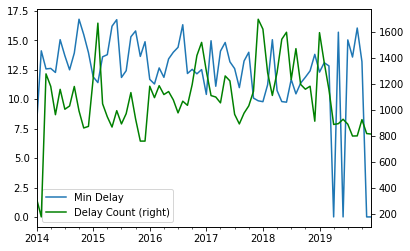

In [36]:
dfmonthav['Min Delay'].plot(legend=True)
# df.B.plot(secondary_y=True, style='g')
dfmonthav['Delay Count'].plot(secondary_y=True, style='g',legend=True)

In [37]:
#ax.set_ylabel('Average Delay')
#ax.right_ax.set_ylabel('Number of delays')
plt.rcParams["figure.figsize"] = [8,4]
plt.show()

# Time Series Forecasting
**Trend** - Trend shows the variation in the output as time increases, often in a non-linear fashion. 

**Level** - The baseline value for a time series.

**Seasonality** - is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year. Any predictable fluctuation or pattern that recurs or repeats over a one-year period is said to be seasonal - from https://www.investopedia.com/terms/s/seasonality.asp

**Noise** - Random variation in the data.

In [38]:
dfmonthav.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-31 to 2019-12-31
Freq: M
Data columns (total 4 columns):
Min Delay                 72 non-null float64
Report Date Time          72 non-null datetime64[ns]
Delay Count               72 non-null int64
Report Date Time_right    72 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 2.8 KB


In [39]:
# add a column to make scatter plot by month convenient
dfmonthav['Month'] = dfmonthav['Report Date Time'].dt.month
dfmonthav.head(20)

Min Delay Report Date Time  Delay Count Report Date Time_right  \
2014-01-31   7.862069       2014-01-31          319             2014-01-31   
2014-02-28  14.117978       2014-02-28          178             2014-02-28   
2014-03-31  12.580595       2014-03-31         1278             2014-03-31   
2014-04-30  12.624365       2014-04-30         1182             2014-04-30   
2014-05-31  12.280083       2014-05-31          964             2014-05-31   
2014-06-30  15.066437       2014-06-30         1159             2014-06-30   
2014-07-31  13.701789       2014-07-31         1006             2014-07-31   
2014-08-31  12.505335       2014-08-31         1031             2014-08-31   
2014-09-30  13.930567       2014-09-30         1181             2014-09-30   
2014-10-31  16.803625       2014-10-31          993             2014-10-31   
2014-11-30  15.501160       2014-11-30          862             2014-11-30   
2014-12-31  13.972540       2014-12-31          874             2014-12-31   
2015-01-31  11.913779       2015-01-31         1241             2015-01-31   
2015-02-28  11.418465       2015-02-28         1668             2015-02-28   
2015-03-31  13.610687       2015-03-31         1048             2015-03-31   
2015-04-30  13.791139       2015-04-30          948             2015-04-30   
2015-05-31  16.212888       2015-05-31          869             2015-05-31   
2015-06-30  16.766834       2015-06-30          995             2015-06-30   
2015-07-31  11.854423       2015-07-31          893             2015-07-31   
2015-08-31  12.429012       2015-08-31          972             2015-08-31   

            Month  
2014-01-31      1  
2014-02-28      2  
2014-03-31      3  
2014-04-30      4  
2014-05-31      5  
2014-06-30      6  
2014-07-31      7  
2014-08-31      8  
2014-09-30      9  
2014-10-31     10  
2014-11-30     11  
2014-12-31     12  
2015-01-31      1  
2015-02-28      2  
2015-03-31      3  
2015-04-30      4  
2015-05-31      5  
2015-06-30      6  
2015-07-31      7  
2015-08-31      8

In [40]:
dfmonthav.head(20)

Min Delay Report Date Time  Delay Count Report Date Time_right  \
2014-01-31   7.862069       2014-01-31          319             2014-01-31   
2014-02-28  14.117978       2014-02-28          178             2014-02-28   
2014-03-31  12.580595       2014-03-31         1278             2014-03-31   
2014-04-30  12.624365       2014-04-30         1182             2014-04-30   
2014-05-31  12.280083       2014-05-31          964             2014-05-31   
2014-06-30  15.066437       2014-06-30         1159             2014-06-30   
2014-07-31  13.701789       2014-07-31         1006             2014-07-31   
2014-08-31  12.505335       2014-08-31         1031             2014-08-31   
2014-09-30  13.930567       2014-09-30         1181             2014-09-30   
2014-10-31  16.803625       2014-10-31          993             2014-10-31   
2014-11-30  15.501160       2014-11-30          862             2014-11-30   
2014-12-31  13.972540       2014-12-31          874             2014-12-31   
2015-01-31  11.913779       2015-01-31         1241             2015-01-31   
2015-02-28  11.418465       2015-02-28         1668             2015-02-28   
2015-03-31  13.610687       2015-03-31         1048             2015-03-31   
2015-04-30  13.791139       2015-04-30          948             2015-04-30   
2015-05-31  16.212888       2015-05-31          869             2015-05-31   
2015-06-30  16.766834       2015-06-30          995             2015-06-30   
2015-07-31  11.854423       2015-07-31          893             2015-07-31   
2015-08-31  12.429012       2015-08-31          972             2015-08-31   

            Month  
2014-01-31      1  
2014-02-28      2  
2014-03-31      3  
2014-04-30      4  
2014-05-31      5  
2014-06-30      6  
2014-07-31      7  
2014-08-31      8  
2014-09-30      9  
2014-10-31     10  
2014-11-30     11  
2014-12-31     12  
2015-01-31      1  
2015-02-28      2  
2015-03-31      3  
2015-04-30      4  
2015-05-31      5  
2015-06-30      6  
2015-07-31      7  
2015-08-31      8

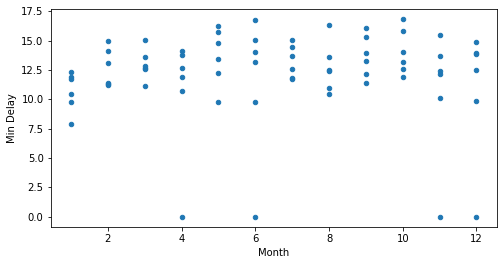

In [41]:
# scatter plot to show mean delay in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Min Delay')
plt.show()

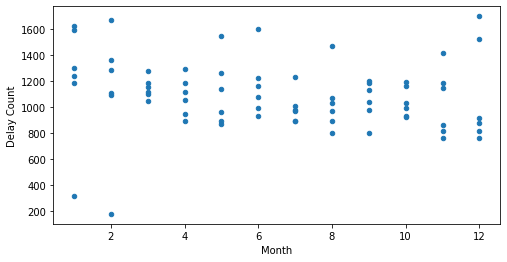

In [42]:
# scatter plot to show delay count in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Delay Count')
plt.show()

# Trend Analysis

Use the built-in Pandas rolling function to smooth the data.

For trend analysis, we use smoothing techniques. 
- In statistics smoothing a data set means to create an approximating function that attempts to capture important patterns in the data, while leaving out noise or other fine-scale structures/rapid phenomena. 
- In smoothing, the data points of a signal are modified so individual points (presumably because of noise) are reduced, and points that are lower than the adjacent points are increased leading to a smoother signal. 

We implement smoothing by taking moving averages. [Exponential moving average](https://www.investopedia.com/terms/e/ema.asp) is frequently used to compute smoothed function.

In [43]:
mean_delay = dfmonthav[['Min Delay']]
count_delay = dfmonthav[['Delay Count']]

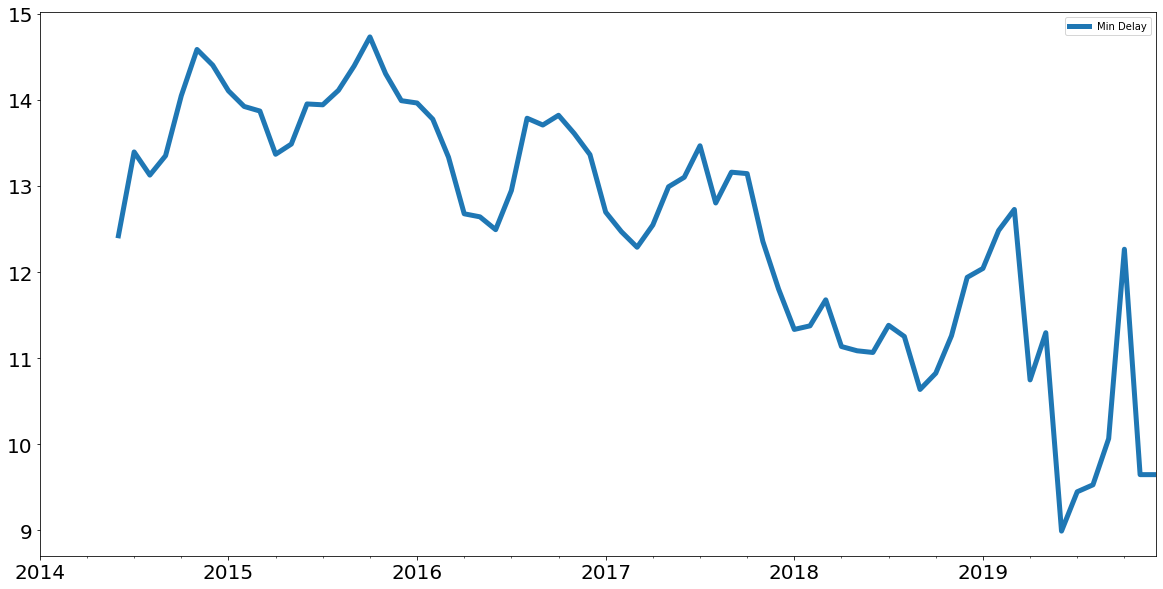

In [44]:
mean_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

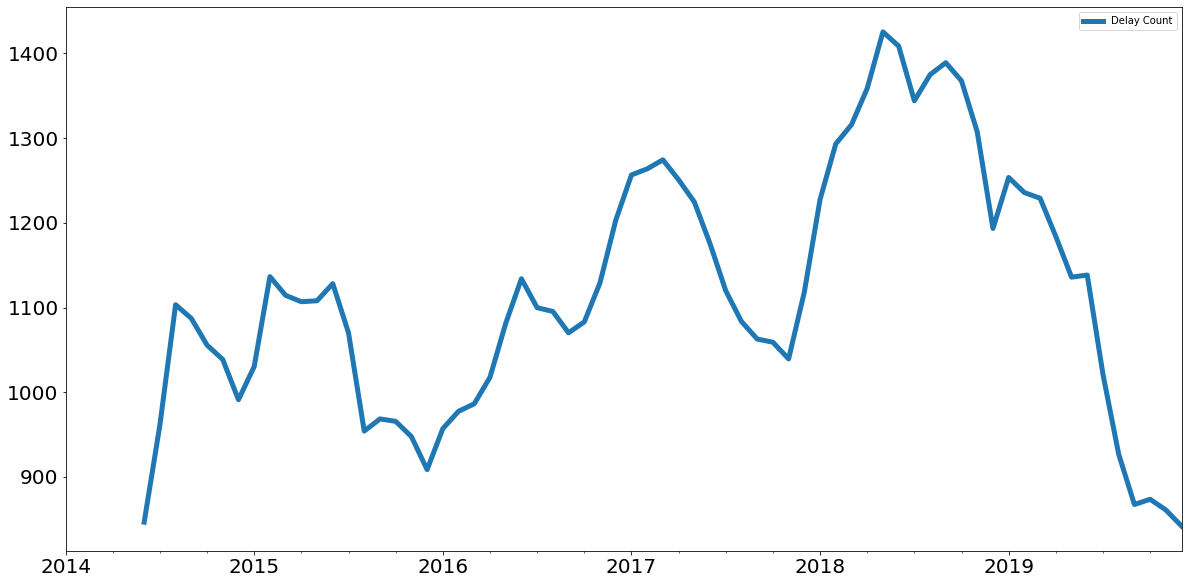

In [45]:
count_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

# Seasonality Analysis

Two examples of seasonality analysis algorithms are:

[Using 1st discrete difference of object](https://machinelearningmastery.com/difference-time-series-dataset-python/)

[Periodicity and Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

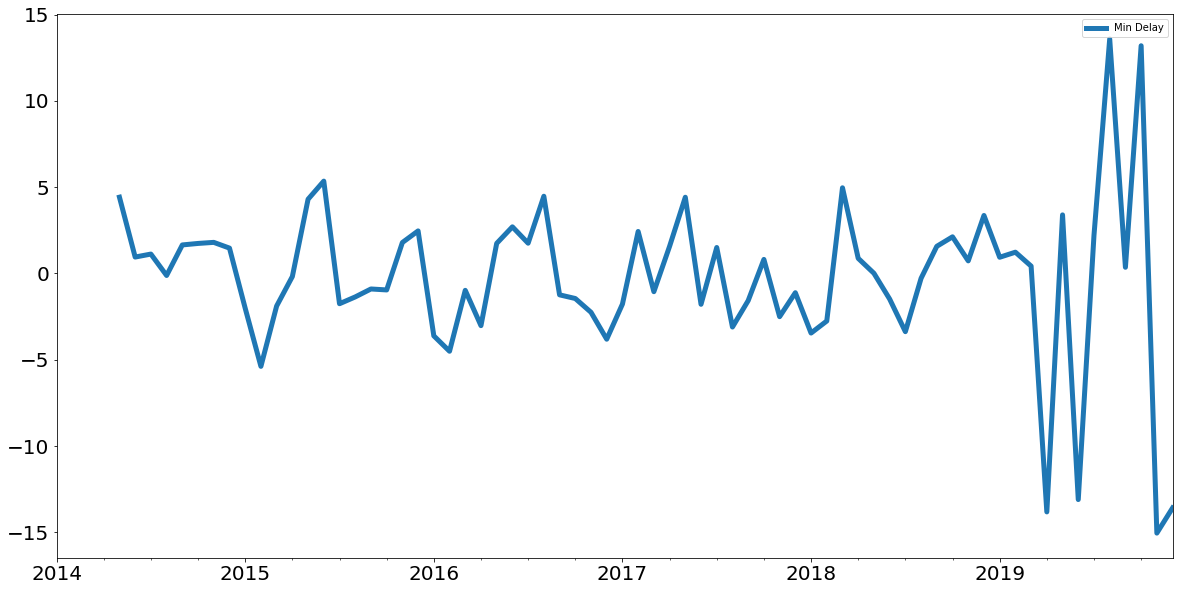

In [46]:
# using 1st discrete difference of object
# This gives us idea about variation of data for a period of time.
mean_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

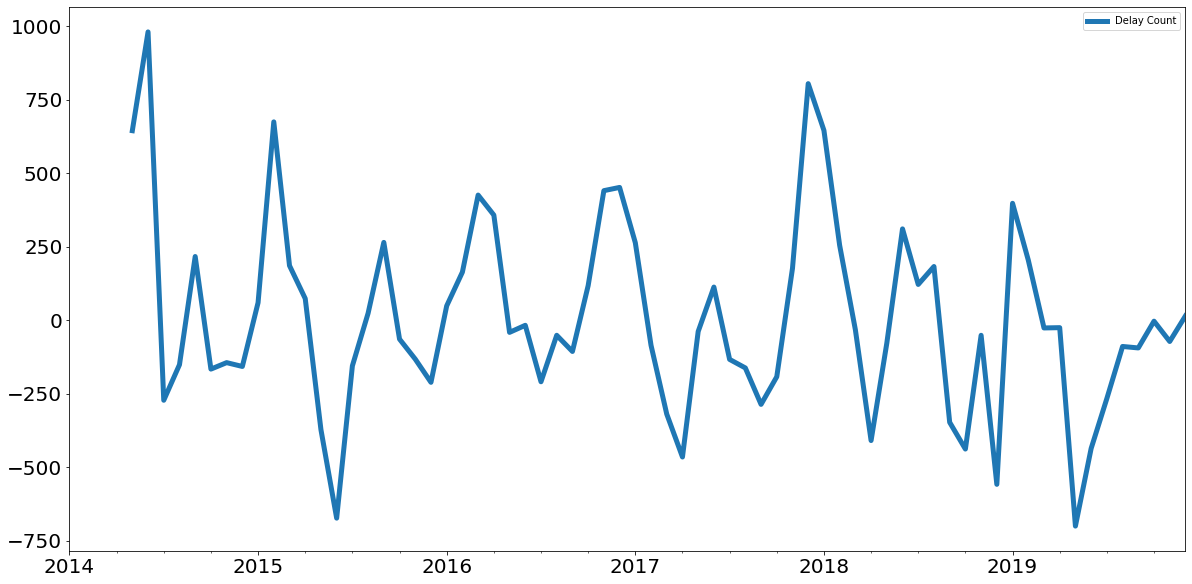

In [47]:
count_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

Auto correlation is the most famous way to understand seasonal variation till now. We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.In this plot vertical axis is represented by the following equations:-

> $C_n = \sum_{t = 1}^{n - h} (y(t) - \hat{y}) (y(t + n) - \hat{y}) / n$

> $C_0 = \sum_{t = 1}^{n} (y(t) - \hat{y})^2 / n$

Horizontal axis represents time lag(previous time steps)  h

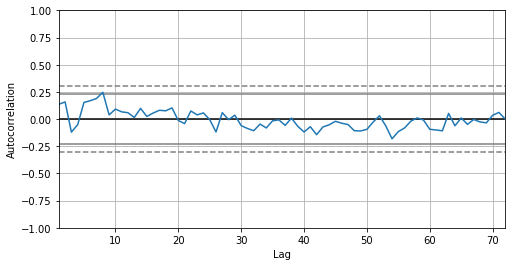

In [48]:
# mean_delay = dfmonthav[['Min Delay']]
# count_delay = dfmonthav[['Delay Count']]


pd.plotting.autocorrelation_plot(dfmonthav['Min Delay'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

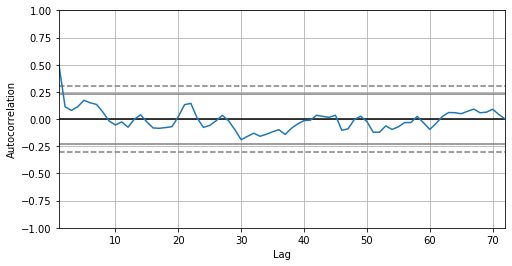

In [49]:
pd.plotting.autocorrelation_plot(dfmonthav['Delay Count'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

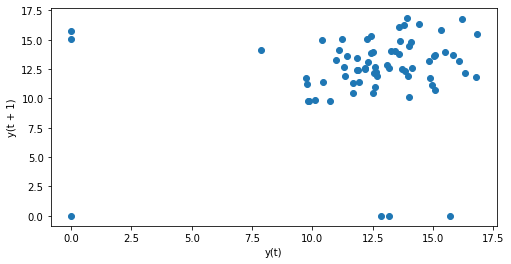

In [50]:
pd.plotting.lag_plot(dfmonthav['Min Delay'])
plt.show()

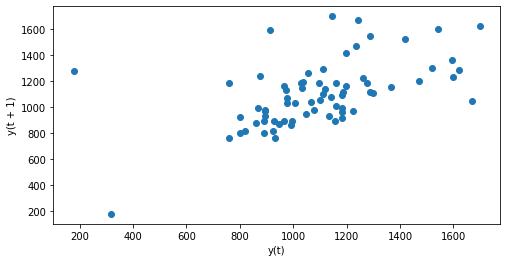

In [51]:
pd.plotting.lag_plot(dfmonthav['Delay Count'])
plt.show()